In [1]:
import zipfile
zip_ref = zipfile.ZipFile('/content/dataset(A&B).zip','r')
zip_ref.extractall()
zip_ref.close()

In [2]:
 #Verify Images
def verify_images(directory):
    broken_images = []
    for root, dirs, files in os.walk(directory):
        for file in files:
            file_path = os.path.join(root, file)
            try:
                img = Image.open(file_path)
                img.verify()
            except Exception as e:
                print(f"Corrupted image: {file_path} | Error: {e}")
                broken_images.append(file_path)
    return broken_images


In [3]:
import os
print(os.listdir("/content/dataset"))
dataset=("/content/dataset")


['Test', 'Train']


In [4]:
#Train/Val Split
def split_dataset(base_dir, val_ratio=0.15):
    classes = os.listdir(base_dir)
    for cls in classes:
        cls_path = os.path.join(base_dir, cls)
        if not os.path.isdir(cls_path):
            continue

        # Only include image files
        images = [f for f in os.listdir(cls_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

        if len(images) == 0:
            print(f"⚠️ No images found in {cls_path}")
            continue

        # Split
        train_imgs, val_imgs = train_test_split(images, test_size=val_ratio, random_state=42)

        # Create validation folder manually
        val_dir = os.path.join(base_dir.replace('Training', 'Validation'), cls)
        os.makedirs(val_dir, exist_ok=True)

        # Move validation images
        for img in val_imgs:
            src = os.path.join(cls_path, img)
            dst = os.path.join(val_dir, img)
            shutil.move(src, dst)

        print(f"✅ Moved {len(val_imgs)} images to {val_dir}")


In [5]:
# Transformations
import torch
from torchvision import transforms

# Define image size and normalization values for Swin Transformer / ImageNet
image_size = 224
mean_vals = [0.485, 0.456, 0.406]
std_vals = [0.229, 0.224, 0.225]

# Define training transformations (with augmentations)
train_transforms = transforms.Compose([
    transforms.Resize((image_size, image_size)),            # Resize to 224x224
    transforms.RandomHorizontalFlip(),                      # Randomly flip image
    transforms.RandomRotation(15),                          # Random rotation
    transforms.ColorJitter(brightness=0.2, contrast=0.2),   # Random brightness/contrast
    transforms.ToTensor(),                                  # Convert PIL to Tensor
    transforms.Normalize(mean=mean_vals, std=std_vals)      # Normalize
])

# Define validation transformations (only resizing and normalization)
val_transforms = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean_vals, std=std_vals)
])


In [6]:
from torchvision import datasets # Import datasets from torchvision
from torch.utils.data import DataLoader
# Load Datasets
def load_datasets(train_path, val_path):
    train_dataset = datasets.ImageFolder(train_path, transform=train_transforms)
    val_dataset = datasets.ImageFolder(val_path, transform=val_transforms)
    train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)
    return train_loader, val_loader, train_dataset.classes


In [7]:
# STEP 7: Display Sample Images
def imshow_batch(loader, classes):
    dataiter = iter(loader)
    images, labels = next(dataiter)

    def unnormalize(img):
        img = img * torch.tensor(std_vals).view(3,1,1) + torch.tensor(mean_vals).view(3,1,1)
        return img

    fig, axes = plt.subplots(1, 5, figsize=(20, 3))
    for i in range(5):
        img = unnormalize(images[i]).permute(1, 2, 0).numpy()
        axes[i].imshow(np.clip(img, 0, 1))
        axes[i].set_title(classes[labels[i]])
        axes[i].axis('off')
    plt.show()

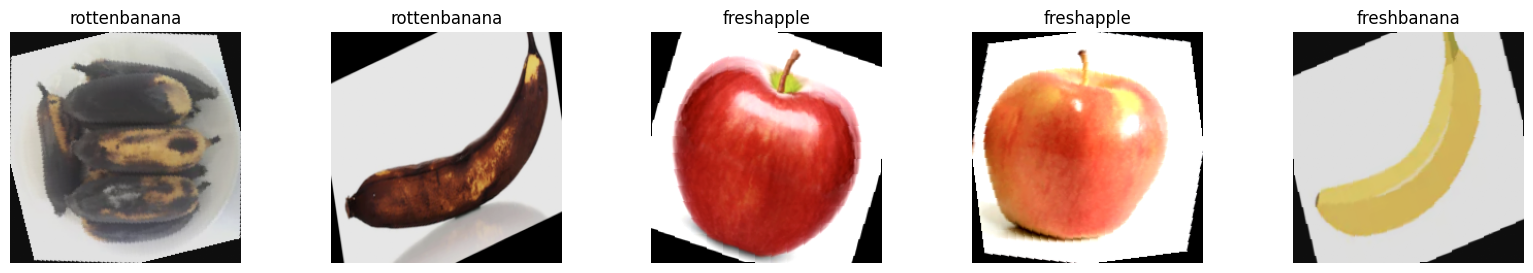

In [8]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

train_path = '/content/dataset/Train'
val_path = '/content/dataset/Test'

# Call load_datasets and assign the output to train_loader, val_loader and class_names
train_loader, val_loader, class_names = load_datasets(train_path, val_path)

# Now you can call imshow_batch:
imshow_batch(train_loader, class_names)